In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
'''
Imports
'''
import datetime
import functools
import itertools
import shelve

import simpy
import scipy.stats
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [4]:
def patch_resource(resource, pre=None, post=None):
    """
    Patch *resource* so that it calls the callable *pre* before each
    put/get/request/release operation and the callable *post* after each
    operation. The only argument to these functions is the resource
    instance.

    Arguments:
        resource: The simpy.resources.container.Container to wrap.
        pre: The function to call before the wrapped function.
        post: The function to call after the wrapped function.
    """
    def get_wrapper(func):
        # Generate a wrapper for put/get/request/release
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # This is the actual wrapper
            # Call "pre" callback
            if pre:
                pre(resource)

            # Perform actual operation
            ret = func(*args, **kwargs)

            # Call "post" callback
            if post:
                post(resource)

            return ret
        return wrapper

    # Replace the original operations with our wrapper
    for name in ['put', 'get', 'request', 'release']:
        if hasattr(resource, name):
            setattr(resource, name, get_wrapper(getattr(resource, name)))
    return resource


def monitor(data, resource):
    """This is our monitoring callback."""
    data.append({
        "clock": resource._env.now,
        "usage": resource.capacity - resource.level,
        "queue": len(resource.get_queue),
        "total": resource.capacity - resource.level + len(resource.get_queue)
    })

In [8]:
# Path to the cleaned SeaWulf Job Scheduler data
data_path = "../../data/seawulf-data.20211111.final.csv"

# Path to the data gathered to determine the distribution of the requested number of nodes
node_data_path = "../../data/squeued.20211125.shelf"

'''
The below functions create samplers for the distributions related to this project;
    1) Interarrival Times
    2) Service Times
    3) Delay
    4) number of requested nodes
'''
def sampler(data):
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit()
    icdf = scipy.interpolate.interp1d(np.linspace(0, 1, num=kde.icdf.size), kde.icdf)
    return lambda: icdf(np.random.uniform(0, 1))


def interarrival_sampler(partition):
    sdata = pd.read_csv(data_path).sort_values(by="SUBMIT_TIME")
    sdata = sdata[sdata.MERGED_PARTITION == partition]

    # Compute interarrival times in hours.
    interarrival_times = (pd.to_datetime(sdata["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values
    return sampler(interarrival_times)


def service_sampler(partition):
    sdata = pd.read_csv(data_path).sort_values(by="SUBMIT_TIME")
    sdata = sdata[sdata.MERGED_PARTITION == partition]

    # Compute service times in hours.
    service_times = (pd.to_timedelta(sdata["SERVICE_TIME"].dropna()) / np.timedelta64(1, "h")).values
    return sampler(service_times)

def delay_sampler(partition):
    sdata = pd.read_csv(data_path).sort_values(by="SUBMIT_TIME")
    sdata = sdata[sdata.MERGED_PARTITION == partition]

    # Compute service times in hours.
    delay_times = (pd.to_timedelta(sdata["DELAY_TIME"].dropna()) / np.timedelta64(1, "h")).values
    return sampler(delay_times)

def nodes_sampler():
    with shelve.open(node_data_path) as db:
        df = pd.DataFrame(db.values())
    smplr = sampler(df.NODES)
    return lambda: int(smplr())

# Helper function that returns the capacity of the given partition of the SeaWulf Cluster
def get_capacity(partition):
    sdata = pd.read_csv(data_path)
    return len(sdata[sdata.MERGED_PARTITION == partition].EXEC_HOST.unique())

In [9]:
def simulate(partition="24core", until=24 * 120):
    '''
    Simulate the given partition of the SeaWulf Cluster for the given number of time steps.

    Arguments:
        partition: The SeaWulf partition to simulate
        until: The number of time steps to run the simulation
    '''
    interarrival = interarrival_sampler(partition)
    service = service_sampler(partition)
    capacity = get_capacity(partition)
    nodes = nodes_sampler()
    
    def source(env, partition):
        cntr = itertools.count(start=0)
        while True:
            # Ensure the number of nodes requested does not exeed the partitions capacity.
            num_nodes = nodes()
            while num_nodes > capacity:
                num_nodes = nodes()
            
            # Wait for next arrival
            yield env.timeout(interarrival())
            # A job has arrived.
            env.process(job(env, partition, next(cntr), num_nodes))


    def job(env, partition, idx, num_nodes):
        # Wait for the required number of nodes to be available.
        req = partition.get(num_nodes)
        yield req

        # We have reserved enough nodes. 
        # 
        yield env.timeout(service())

        # Release the nodes back to the container
        rel = partition.put(num_nodes)
        yield rel
            

    # Setup the simpy.Environment to launch our simulator with.
    data = []
    env = simpy.Environment()
    partition = patch_resource(
        simpy.resources.container.Container(env, capacity=round(capacity), init=round(capacity)),
        pre=functools.partial(monitor, data)
    )
    env.process(source(env, partition))
    env.run(until=until)
    return pd.DataFrame(data).set_index("clock")

array([<AxesSubplot:xlabel='clock'>, <AxesSubplot:xlabel='clock'>,
       <AxesSubplot:xlabel='clock'>], dtype=object)

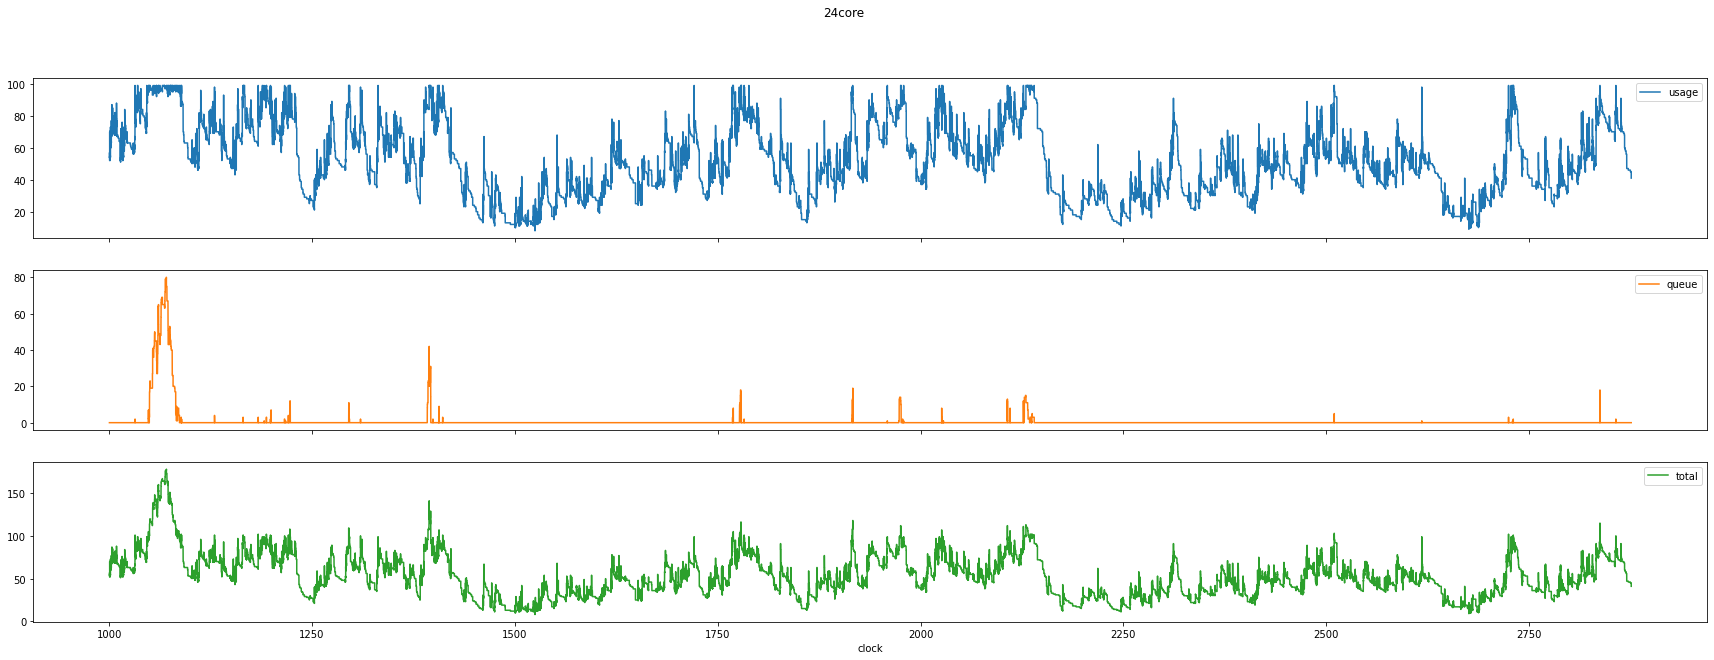

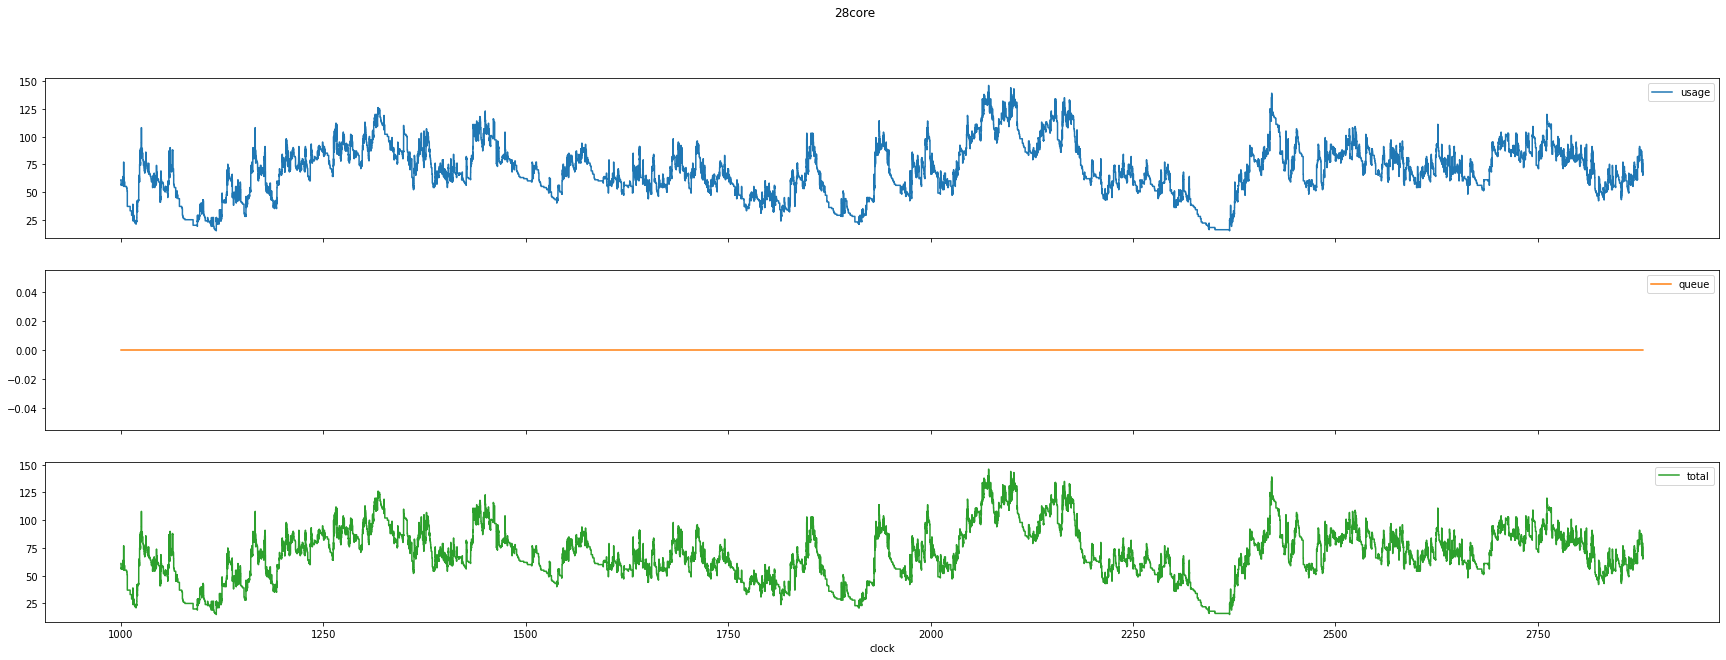

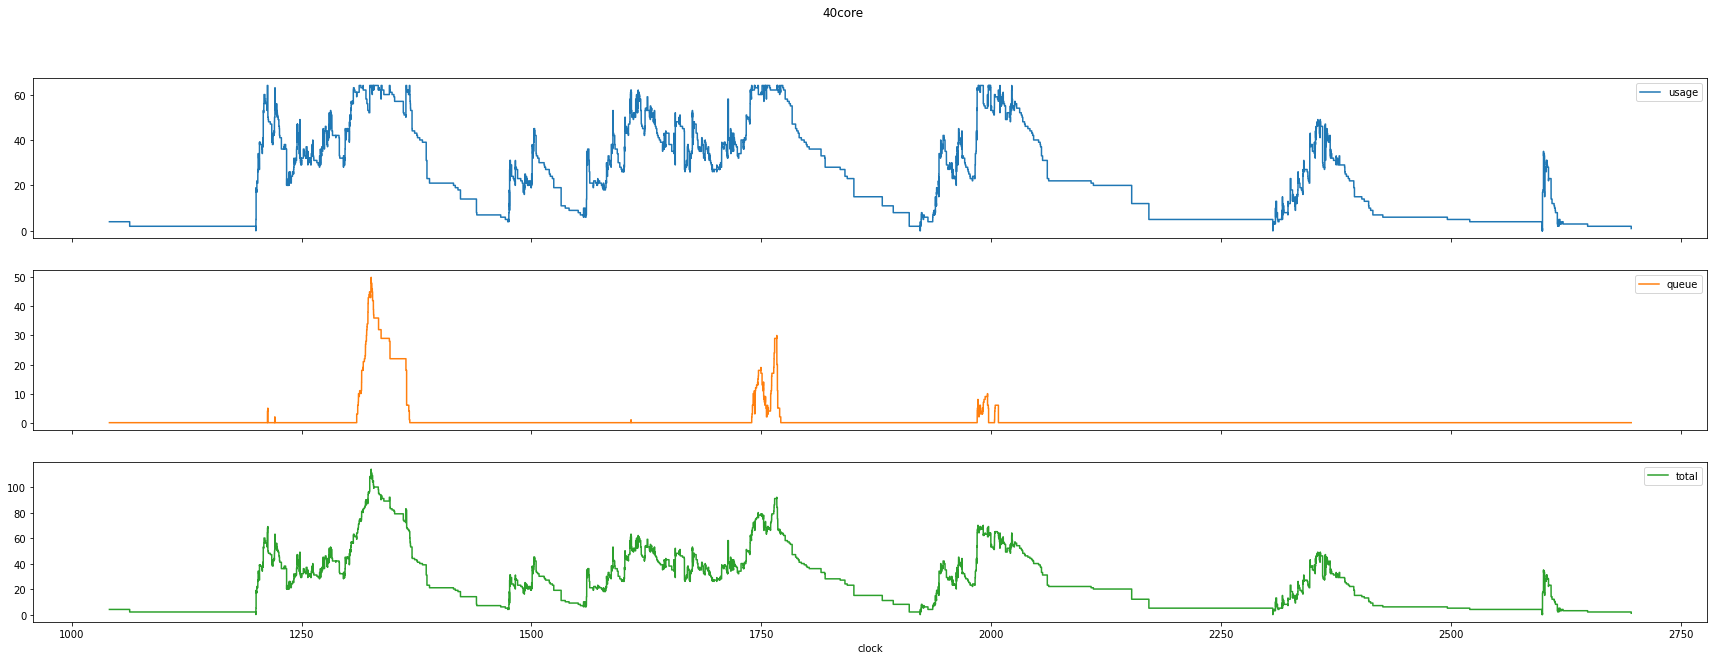

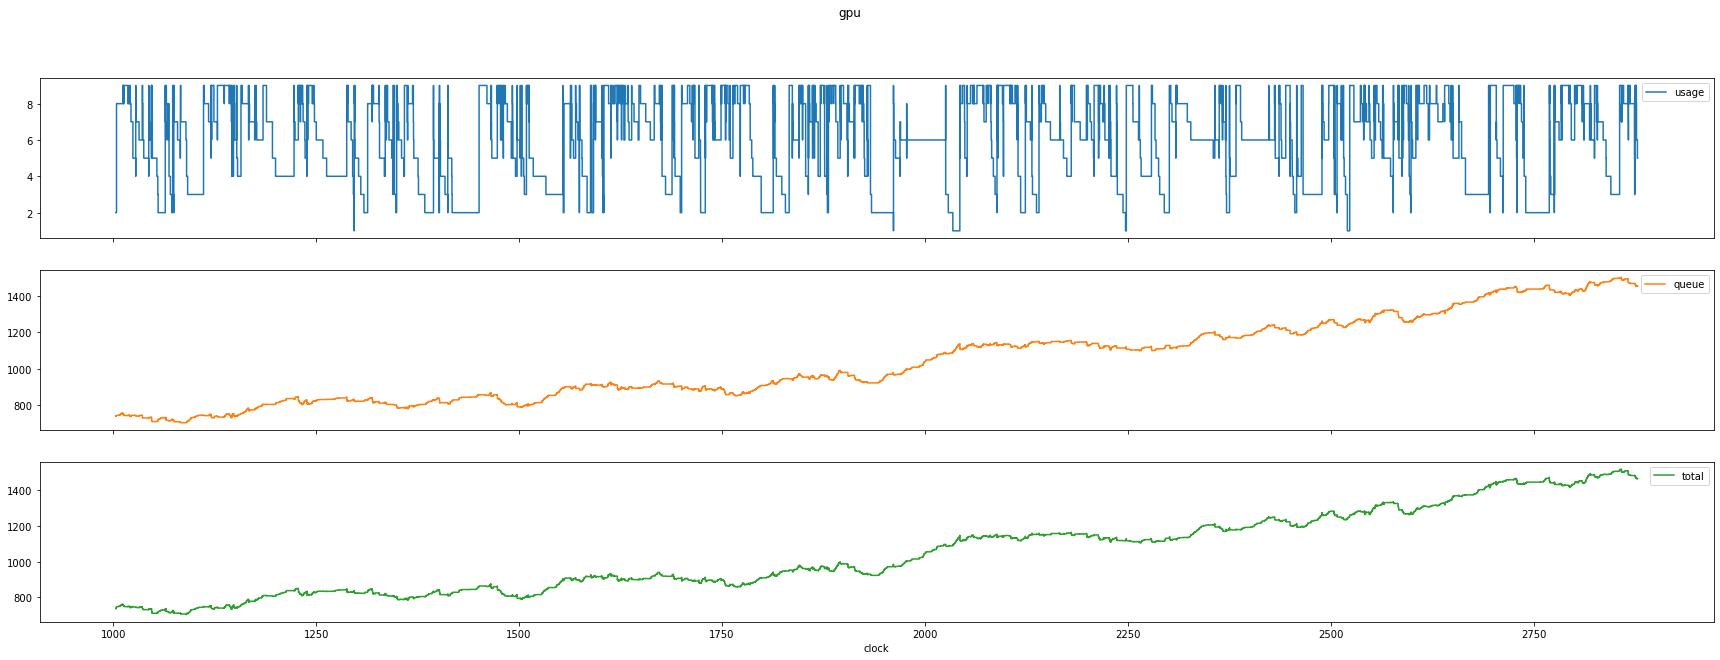

In [12]:
simulate("24core")[1000:].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="24core")
simulate("28core")[1000:].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="28core")
simulate("40core")[1000:].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="40core")
simulate("gpu")[1000:].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="gpu")

In [13]:
'''
Actual data Statistics
'''
# Paths to data files
data_path = "../../data/seawulf-data.20211111.final.csv"
node_data_path = "../../data/squeued.20211125.shelf"

# Read in the Data
df = pd.read_csv(data_path).sort_values(by="SUBMIT_TIME")
with shelve.open(node_data_path) as db:
        df2 = pd.DataFrame(db.values())
num_nodes_list = df2.NODES

# Calculate sample data statistics
for partition in ["24core", "28core", "40core", "gpu"]:
    sdata = df[df.MERGED_PARTITION == partition]
    inter_list = (pd.to_datetime(sdata["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values
    delay = delay_sampler(partition)
    del_list = (pd.to_timedelta(sdata["DELAY_TIME"].dropna()) / np.timedelta64(1, "h")).values
    serv_list = (pd.to_timedelta(sdata["SERVICE_TIME"].dropna()) / np.timedelta64(1, "h")).values
    cap = len(sdata.EXEC_HOST.unique())

    print(f"Partition: {partition}")
    print(f"Capacity: {cap}")
    print(f"mean/min/max interarrival time: {np.mean(inter_list):0.5} | {np.min(inter_list):0.5} | {np.max(inter_list):0.5}")
    print(f"mean/min/max service time: {np.mean(serv_list):0.5} | {np.min(serv_list):0.5} | {np.max(serv_list):0.5}")
    print(f"mean/min/max delay time: {np.mean(del_list):0.5} | {np.min(del_list):0.5} | {np.max(del_list):0.5}")
    print(f"mean/min/max number of requested nodes: {np.mean(num_nodes_list):0.5} | {np.min(num_nodes_list)} | {np.max(num_nodes_list)}")
    print(f"Average nodes in use: {(np.mean(num_nodes_list)*np.mean(serv_list))/(np.mean(inter_list))}")
    print(f"Average utilization: {(np.mean(num_nodes_list)*np.mean(serv_list))/(np.mean(inter_list)*cap)}\n")

Partition: 24core
Capacity: 99
mean/min/max interarrival time: 0.19974 | 0.0 | 20.916
mean/min/max service time: 4.6066 | 0.0 | 168.01
mean/min/max delay time: 1.1352 | 0.0 | 138.89
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Average nodes in use: 45.742072102066956
Average utilization: 0.4620411323441107

Partition: 28core
Capacity: 146
mean/min/max interarrival time: 0.26512 | 0.0 | 28.044
mean/min/max service time: 8.7831 | 0.0 | 168.01
mean/min/max delay time: 1.4535 | 0.0 | 166.95
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Average nodes in use: 65.7056300843766
Average utilization: 0.45003856222175753

Partition: 40core
Capacity: 64
mean/min/max interarrival time: 1.0403 | 0.0 | 288.41
mean/min/max service time: 12.988 | 0.0 | 168.01
mean/min/max delay time: 6.4177 | 0.0 | 465.68
mean/min/max number of requested nodes: 1.9834 | 1 | 16
Average nodes in use: 24.76161257648534
Average utilization: 0.38690019650758345

Partition: gpu
Capacity: 9
mean/min/max i

In [14]:
'''
Simulated data Statistics
'''
n = 100000
for partition in ["24core", "28core", "40core", "gpu"]:
    # Create the samplers to generate the sample data
    interarrival = interarrival_sampler(partition)
    service = service_sampler(partition)
    delay = delay_sampler(partition)
    nodes = nodes_sampler()

    # The capacity of the current partition
    cap = get_capacity(partition)

    inter_list = []
    del_list = []
    serv_list = []
    num_nodes_list = []

    # Gather n sample points
    for i in range(n):
        # Ensure the number of requested nodes does not exeed the capacity
        num = nodes()
        while num > cap:
            num = nodes()

        inter_list.append(interarrival())
        del_list.append(delay())
        serv_list.append(service())
        num_nodes_list.append(num)

    # Print out the statistics for the current partition
    print(f"Partition: {partition}")
    print(f"Capacity: {cap}")
    print(f"mean/min/max interarrival time: {np.mean(inter_list):0.5} | {np.min(inter_list):0.5} | {np.max(inter_list):0.5}")
    print(f"mean/min/max service time: {np.mean(serv_list):0.5} | {np.min(serv_list):0.5} | {np.max(serv_list):0.5}")
    print(f"mean/min/max delay time: {np.mean(del_list):0.5} | {np.min(del_list):0.5} | {np.max(del_list):0.5}")
    print(f"mean/min/max number of requested nodes: {np.mean(num_nodes_list):0.5} | {np.min(num_nodes_list)} | {np.max(num_nodes_list)}")
    print(f"Average nodes in use: {(np.mean(num_nodes_list)*np.mean(serv_list))/(np.mean(inter_list))}")
    print(f"Average utilization: {(np.mean(num_nodes_list)*np.mean(serv_list))/(np.mean(inter_list)*cap)}\n")

Partition: 24core
Capacity: 99
mean/min/max interarrival time: 0.20072 | 0.0 | 20.909
mean/min/max service time: 4.6427 | 2.0858e-07 | 168.01
mean/min/max delay time: 1.1523 | 0.0 | 138.39
mean/min/max number of requested nodes: 1.9697 | 1 | 16
Average nodes in use: 45.55835365141858
Average utilization: 0.4601853904183695

Partition: 28core
Capacity: 146
mean/min/max interarrival time: 0.27374 | 0.0 | 28.038
mean/min/max service time: 8.8127 | 0.0 | 168.01
mean/min/max delay time: 1.4713 | 0.0 | 166.18
mean/min/max number of requested nodes: 1.9619 | 1 | 16
Average nodes in use: 63.162319457014235
Average utilization: 0.4326186264179057

Partition: 40core
Capacity: 64
mean/min/max interarrival time: 1.0854 | 0.0 | 288.33
mean/min/max service time: 13.019 | 0.0 | 168.01
mean/min/max delay time: 6.531 | 0.0 | 465.68
mean/min/max number of requested nodes: 1.9707 | 1 | 16
Average nodes in use: 23.636919858142004
Average utilization: 0.3693268727834688

Partition: gpu
Capacity: 9
mean/min

In [54]:
def simulate_2(partition="24core", until=24 * 120):
    '''
    Simulate the given partition of the SeaWulf Cluster for the given number of time steps.

    Arguments:
        partition: The SeaWulf partition to simulate
        until: The number of time steps to run the simulation
    '''
    interarrival = interarrival_sampler(partition)
    service = service_sampler(partition)
    nodes = nodes_sampler()

    # Lists to keep track of generated samples
    interarrivals_list = []
    start_list = []
    end_list = []
    delays_list = []
    service_list = []
    num_nodes_list = []

    capacity = -1
    if partition == "24core":
        capacity = 60
    elif partition == "28core":
        capacity = 80
    elif partition == "40core":
        capacity = 40
    elif partition == "gpu":
        capacity = 15
    
    def source(env, partition):
        cntr = itertools.count(start=0)
        while True:
            # Ensure the number of nodes requested does not exeed the partitions capacity.
            num_nodes = nodes()
            while num_nodes > capacity:
                num_nodes = nodes()
            
            # Update sample lists
            num_nodes_list.append(num_nodes)
            inter = interarrival()
            interarrivals_list.append(inter)

            # Wait for next arrival
            yield env.timeout(inter)
            start_list.append(env.now())
            # A job has arrived.
            env.process(job(env, partition, next(cntr), num_nodes))


    def job(env, partition, idx, num_nodes):
        # Wait for the required number of nodes to be available.
        req = partition.get(num_nodes)
        yield req

        # Update sample service time list
        ser = service()
        service_list.append(ser)

        yield env.timeout(ser)

        end_list.append(env.now())

        # Release the nodes back to the container
        rel = partition.put(num_nodes)
        yield rel
            

    # Setup the simpy.Environment to launch our simulator with.
    data = []
    env = simpy.Environment()
    partition = patch_resource(
        simpy.resources.container.Container(env, capacity=round(capacity), init=round(capacity)),
        pre=functools.partial(monitor, data)
    )
    env.process(source(env, partition))
    env.run(until=until)

    # Prepare the delay data
    start_list = start_list[:len(end_list)] # Only count the jobs that finished.
    temp = (np.array(end_list) - np.array(start_list))
    print(f"type : {type(temp[0])}")
    delays_list = (temp / np.timedelta64(1, "h"))
    print(f"type : {delays_list}")
    return (pd.DataFrame(data).set_index("clock"), interarrivals_list.copy(), delays_list.copy(), service_list.copy(), num_nodes_list.copy())

type : <class 'numpy.timedelta64'>
type : [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.72222222e-06
 6.39361111e-06 8.05944444e-06]
type : <class 'numpy.timedelta64'>
type : [2.64166667e-07 2.64166667e-07 5.41944444e-07 ... 1.41972222e-06
 1.41972222e-06 1.41972222e-06]
type : <class 'numpy.timedelta64'>
type : [3.02222222e-07 5.54722222e-07 2.52500000e-07 ... 1.92888889e-06
 1.92888889e-06 1.92888889e-06]
type : <class 'numpy.timedelta64'>
type : [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.77777778e-07
 2.77777778e-07 0.00000000e+00]


array([<AxesSubplot:xlabel='clock'>, <AxesSubplot:xlabel='clock'>,
       <AxesSubplot:xlabel='clock'>], dtype=object)

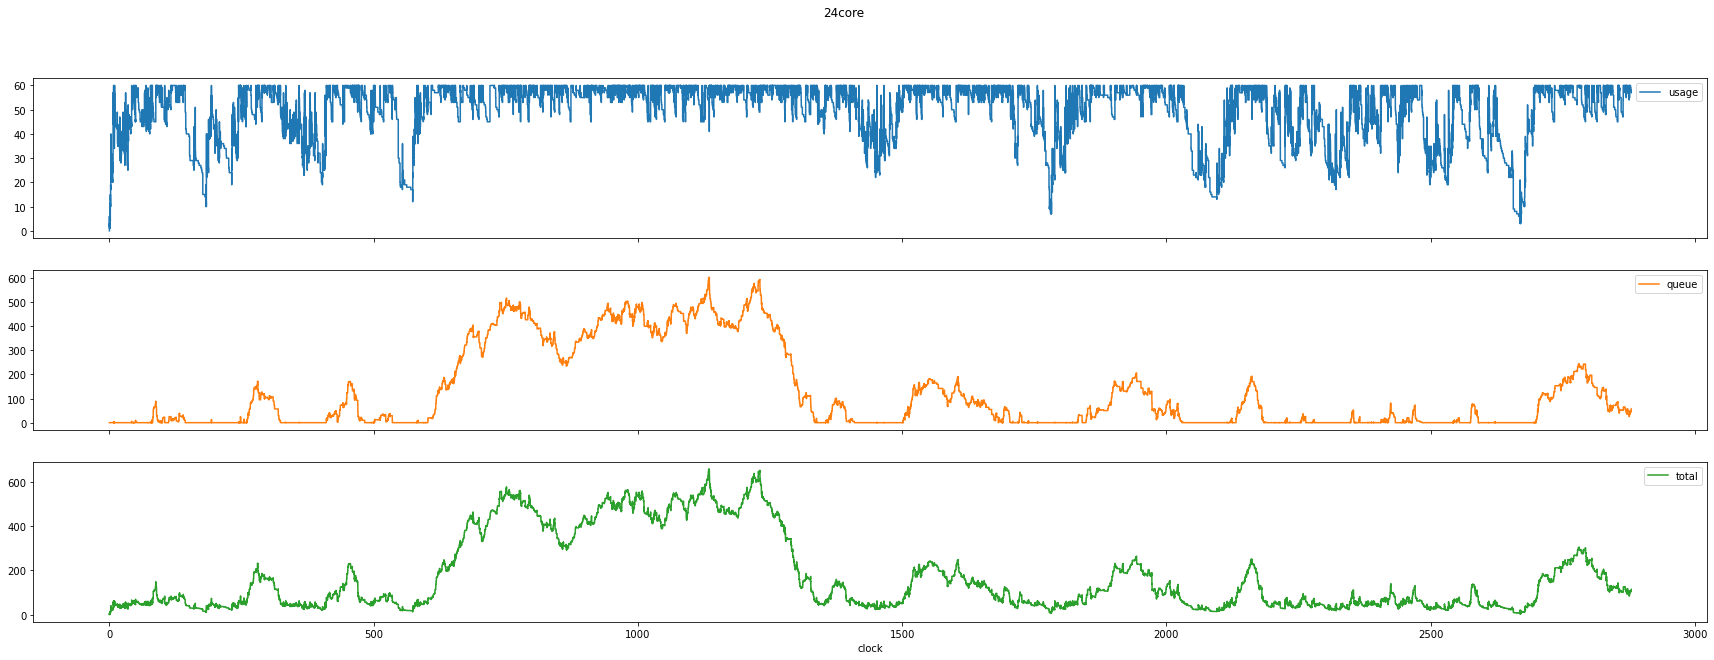

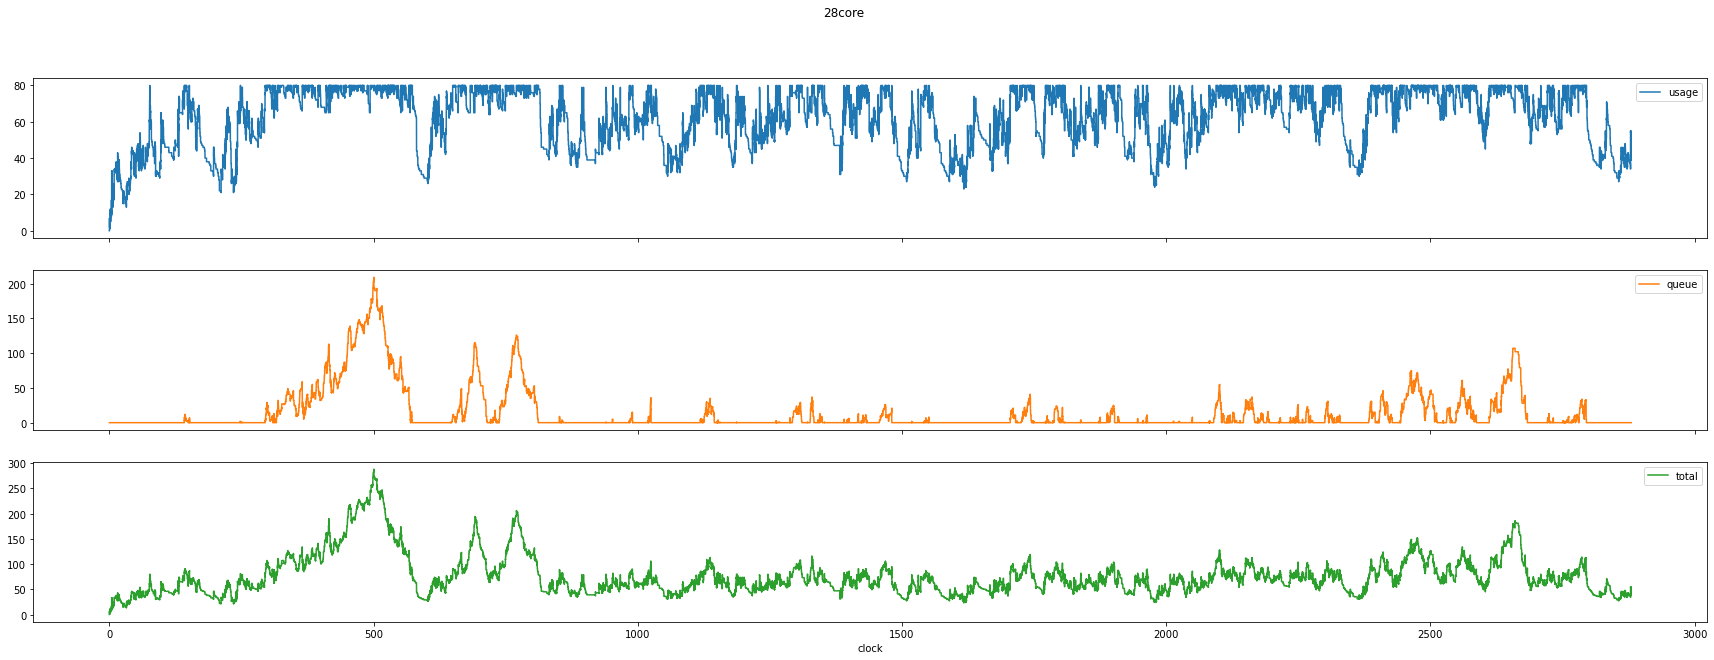

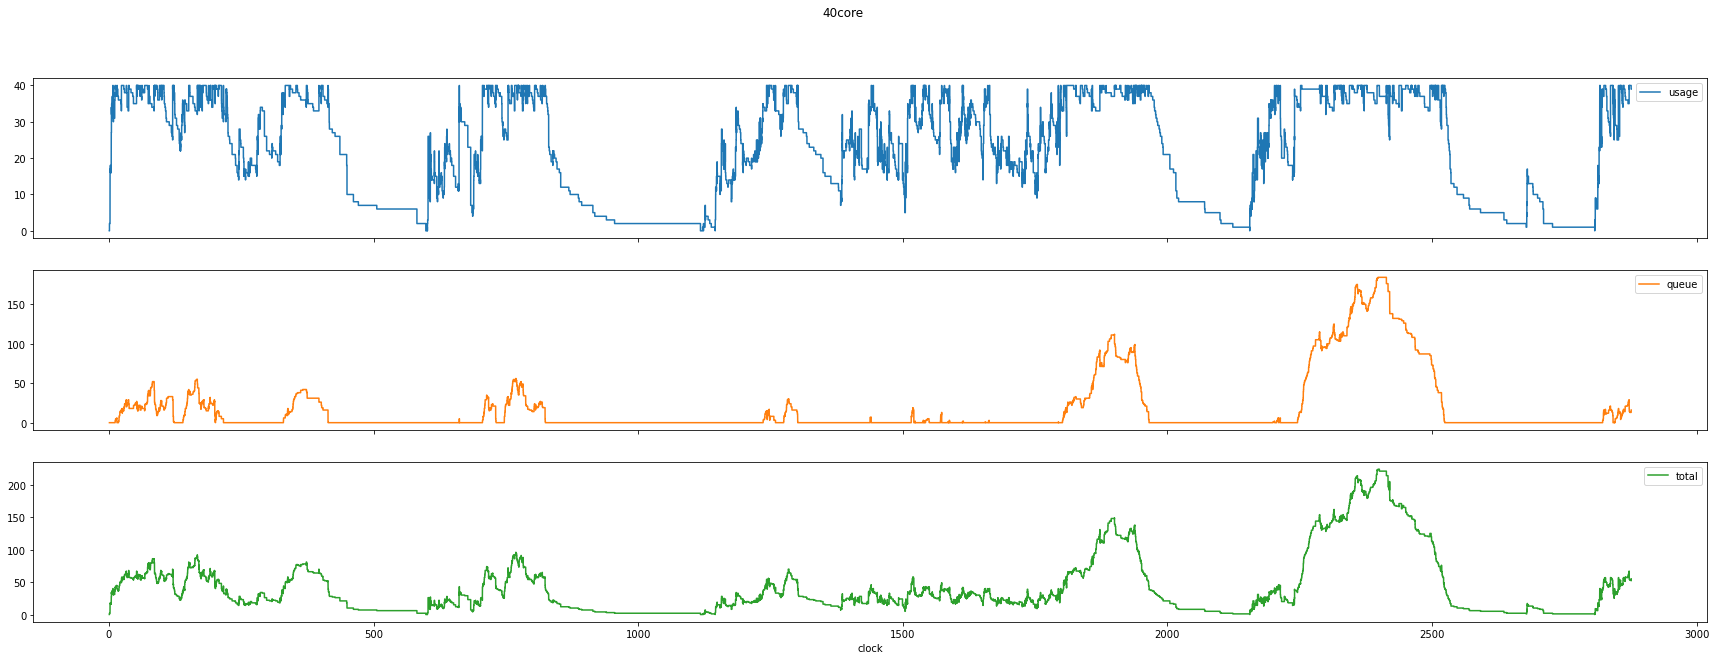

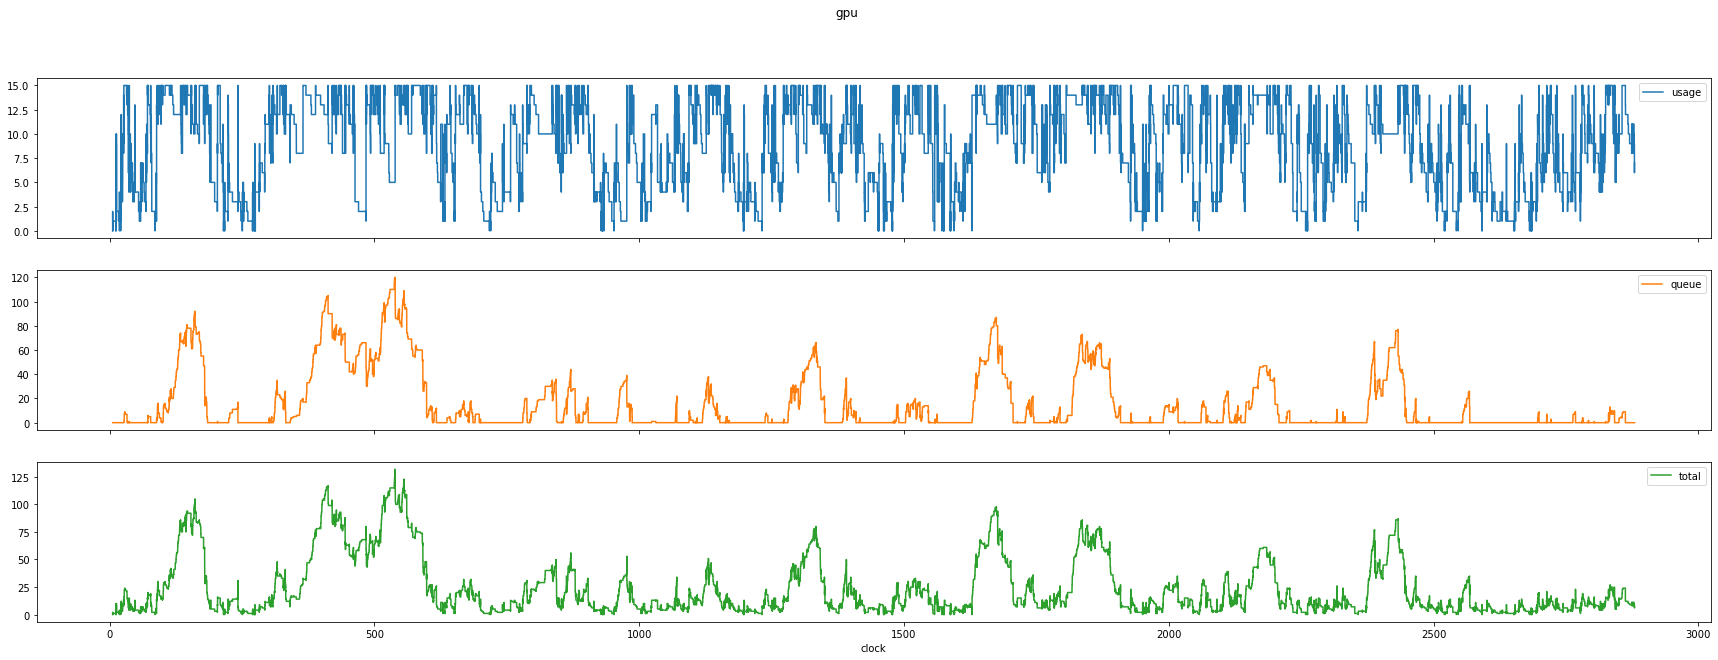

In [55]:
sim2_24core = simulate_2("24core")
sim2_24core[0].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="24core")
sim2_28core = simulate_2("28core")
sim2_28core[0].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="28core")
sim2_40core = simulate_2("40core")
sim2_40core[0].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="40core")
sim2_gpu = simulate_2("gpu")
sim2_gpu[0].plot(figsize=(30, 10), drawstyle="steps-post", subplots=True, title="gpu")

In [29]:
'''NOTE:
    sim2_xxcore[1] are the interarrival times
    sim2_xxcore[2] are the service times
    sim2_xxcore[3] are the delay times
    sim2_xxcore[4] are the number of requested nodes
'''

sim_dict = {"24core":sim2_24core, "28core":sim2_28core, "40core":sim2_40core, "gpu":sim2_gpu}
cap = {"24core":60, "28core":80, "40core":40, "gpu":15}

for partition in ["24core", "28core", "40core", "gpu"]: 
    # Print out the statistics for the current partition
    print(f"Partition: {partition}")
    print(f"Capacity: {cap[partition]}")
    print(f"mean/min/max interarrival time: {np.mean(sim_dict[partition][1]):0.5} | {np.min(sim_dict[partition][1]):0.5} | {np.max(sim_dict[partition][1]):0.5}")
    print(f"mean/min/max service time: {np.mean(sim_dict[partition][2]):0.5} | {np.min(sim_dict[partition][2]):0.5} | {np.max(sim_dict[partition][2]):0.5}")
    print(f"mean/min/max delay time: {np.mean(sim_dict[partition][3]):0.5} | {np.min(sim_dict[partition][3]):0.5} | {np.max(sim_dict[partition][3]):0.5}")
    print(f"mean/min/max number of requested nodes: {np.mean(sim_dict[partition][4]):0.5} | {np.min(sim_dict[partition][4])} | {np.max(sim_dict[partition][4])}")
    print(f"Average nodes in use: {(np.mean(sim_dict[partition][4])*np.mean(sim_dict[partition][2]))/(np.mean(sim_dict[partition][1]))}")
    print(f"Average utilization: {(np.mean(sim_dict[partition][4])*np.mean(sim_dict[partition][2]))/(np.mean(sim_dict[partition][1])*cap)}\n")

Partition: 24core
Capacity: 60
mean/min/max interarrival time: 0.20224 | 0.0 | 20.907


TypeError: unsupported operand type(s) for +: 'datetime.datetime' and 'datetime.datetime'